# Disaster Tweets: Natural Language Processing

## Step 1: Set Up the Environment

### 1.1 Install Libraries and Tools

In [1]:
# !pip install pandas numpy scikit-learn matplotlib seaborn nltk spacy xgboost lightgbm streamlit imbalanced-learn
!pip install xgboost
!pip install --upgrade pip setuptools
!pip install lightgbm


### 1.2 Import Libraries

In [2]:
import numpy as np
import pandas as pd
import re, string, nltk
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

### 1.3 Import Specific tools

In [3]:
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.utils import resample
from sklearn.utils.class_weight import compute_class_weight
from sklearn.tree import DecisionTreeClassifier
from collections import Counter 
from wordcloud import WordCloud
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline as ImbPipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier


from lightgbm import LGBMClassifier

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer

# Ottieni le stopwords in inglese
stop_words = set(stopwords.words('english'))

# Scarica i pacchetti necessari se non sono stati scaricati
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/cosimocarl/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/cosimocarl/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Step 2: Data Preprocessing

### 2.1 - Import Data

In [4]:
df = pd.read_csv('data/Data.csv')

# View the first few rows of each dataframe to understand its structure
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


### 2.2 - Data Exploration

In [5]:
# Df info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [6]:
# Df Types
df.dtypes

id           int64
keyword     object
location    object
text        object
target       int64
dtype: object

In [7]:
# Check the column
df.columns

Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')

In [8]:
# Check the Class Balance
df.target.value_counts(normalize=True)

target
0    0.57034
1    0.42966
Name: proportion, dtype: float64

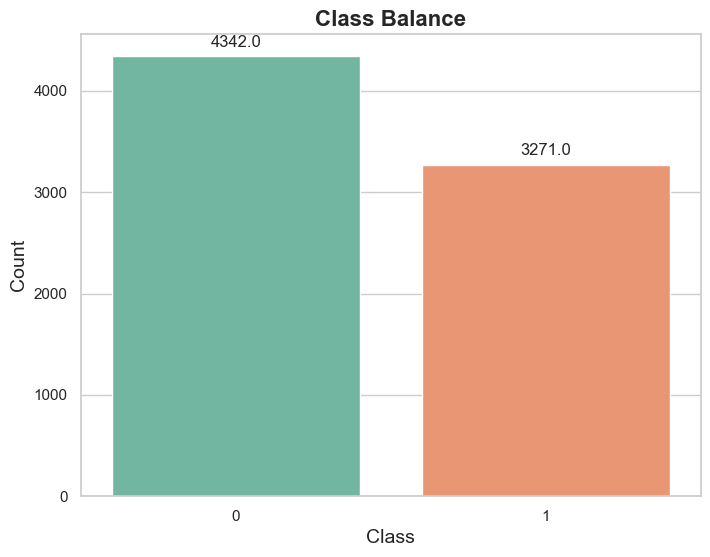

In [9]:
# Chart
# Style and dimension 
sns.set(style="whitegrid")
plt.figure(figsize=(8,6))

sns.countplot(x='target', data=df, palette='Set2', hue='target', legend=False)

for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height()}',
                       (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='center', xytext=(0, 10),
                       textcoords='offset points')

plt.title('Class Balance', fontsize=16, fontweight='bold')
plt.xlabel('Class', fontsize=14)
plt.ylabel('Count', fontsize=14)

plt.show()

<Axes: title={'center': 'Tweet Length Distribution'}, ylabel='Frequency'>

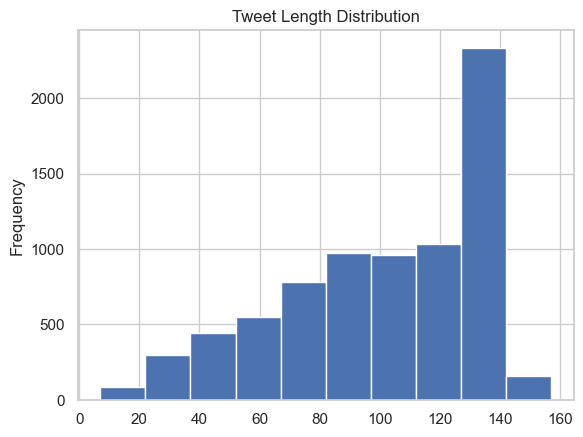

In [10]:
# Tweet Length Distribution
df['text_length'] = df['text'].apply(len)
df['text_length'].plot(kind='hist', title='Tweet Length Distribution')

In [11]:
# Check unique value 'id'
df['id'].unique()

array([    1,     4,     5, ..., 10871, 10872, 10873])

In [12]:
#Check unique value 'keyword'
df.keyword.unique()

array([nan, 'ablaze', 'accident', 'aftershock', 'airplane%20accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown%20up', 'body%20bag', 'body%20bagging',
       'body%20bags', 'bomb', 'bombed', 'bombing', 'bridge%20collapse',
       'buildings%20burning', 'buildings%20on%20fire', 'burned',
       'burning', 'burning%20buildings', 'bush%20fires', 'casualties',
       'casualty', 'catastrophe', 'catastrophic', 'chemical%20emergency',
       'cliff%20fall', 'collapse', 'collapsed', 'collide', 'collided',
       'collision', 'crash', 'crashed', 'crush', 'crushed', 'curfew',
       'cyclone', 'damage', 'danger', 'dead', 'death', 'deaths', 'debris',
       'deluge', 'deluged', 'demolish', 'demolished', 'demolition',
       'derail', 'der

In [13]:
# Check unique value 'location'
df.location.unique()

array([nan, 'Birmingham', 'Est. September 2012 - Bristol', ...,
       'Vancouver, Canada', 'London ', 'Lincoln'], dtype=object)

In [14]:
# Calculate the number of unique (distinct) values ​​in each column
df.nunique()

id             7613
keyword         221
location       3341
text           7503
target            2
text_length     147
dtype: int64

In [15]:
# Check duplicate
df.duplicated().value_counts()

False    7613
Name: count, dtype: int64

### 2.3 Data Cleaning

In [16]:
df.head()

,id,keyword,location,text,target,text_length
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88


#### Imputation of missing value 

<Axes: >

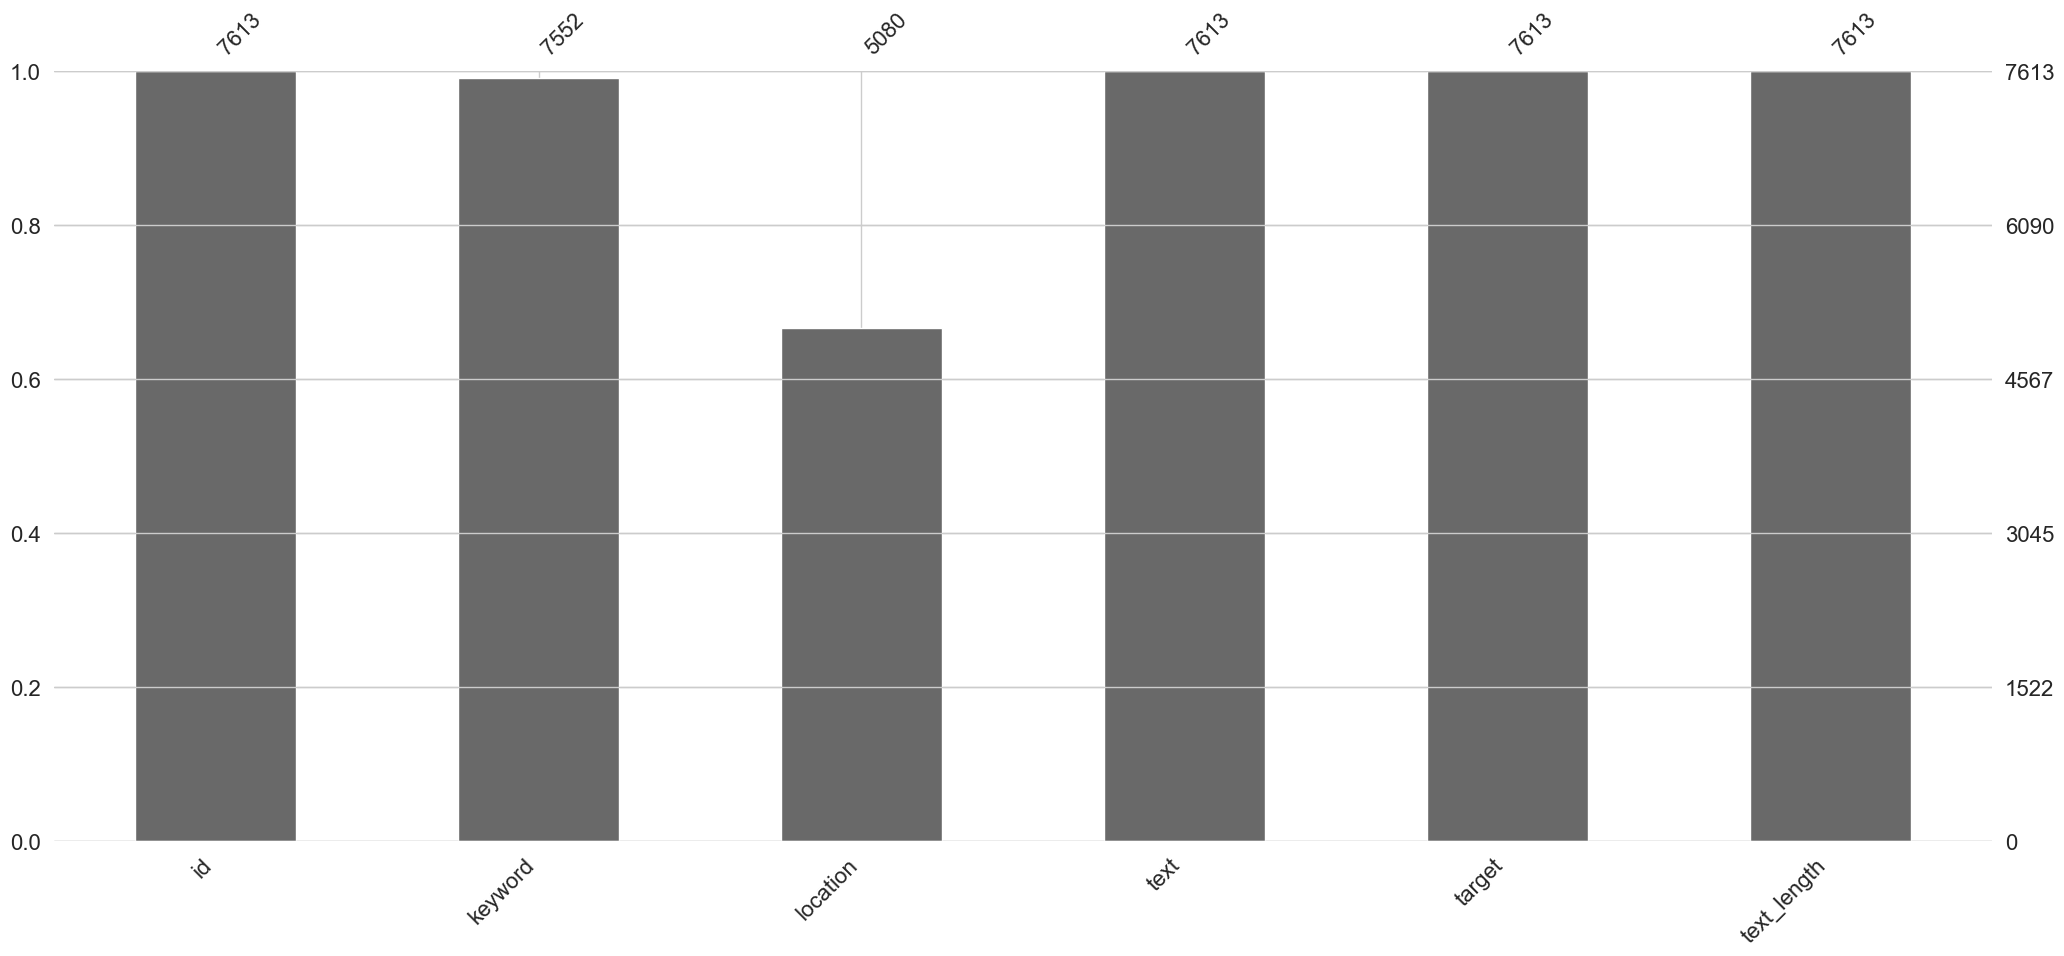

In [17]:
#Visualize the missing value distribution
msno.bar(df)

In [18]:
# Fill in the missing values ​​with "Unknown"
df['location'] = df['location'].fillna("Unknown")
df['keyword'] = df['keyword'].fillna("Unknown")

In [19]:
# Check missing value 
df.isna().sum()

id             0
keyword        0
location       0
text           0
target         0
text_length    0
dtype: int64

<Axes: >

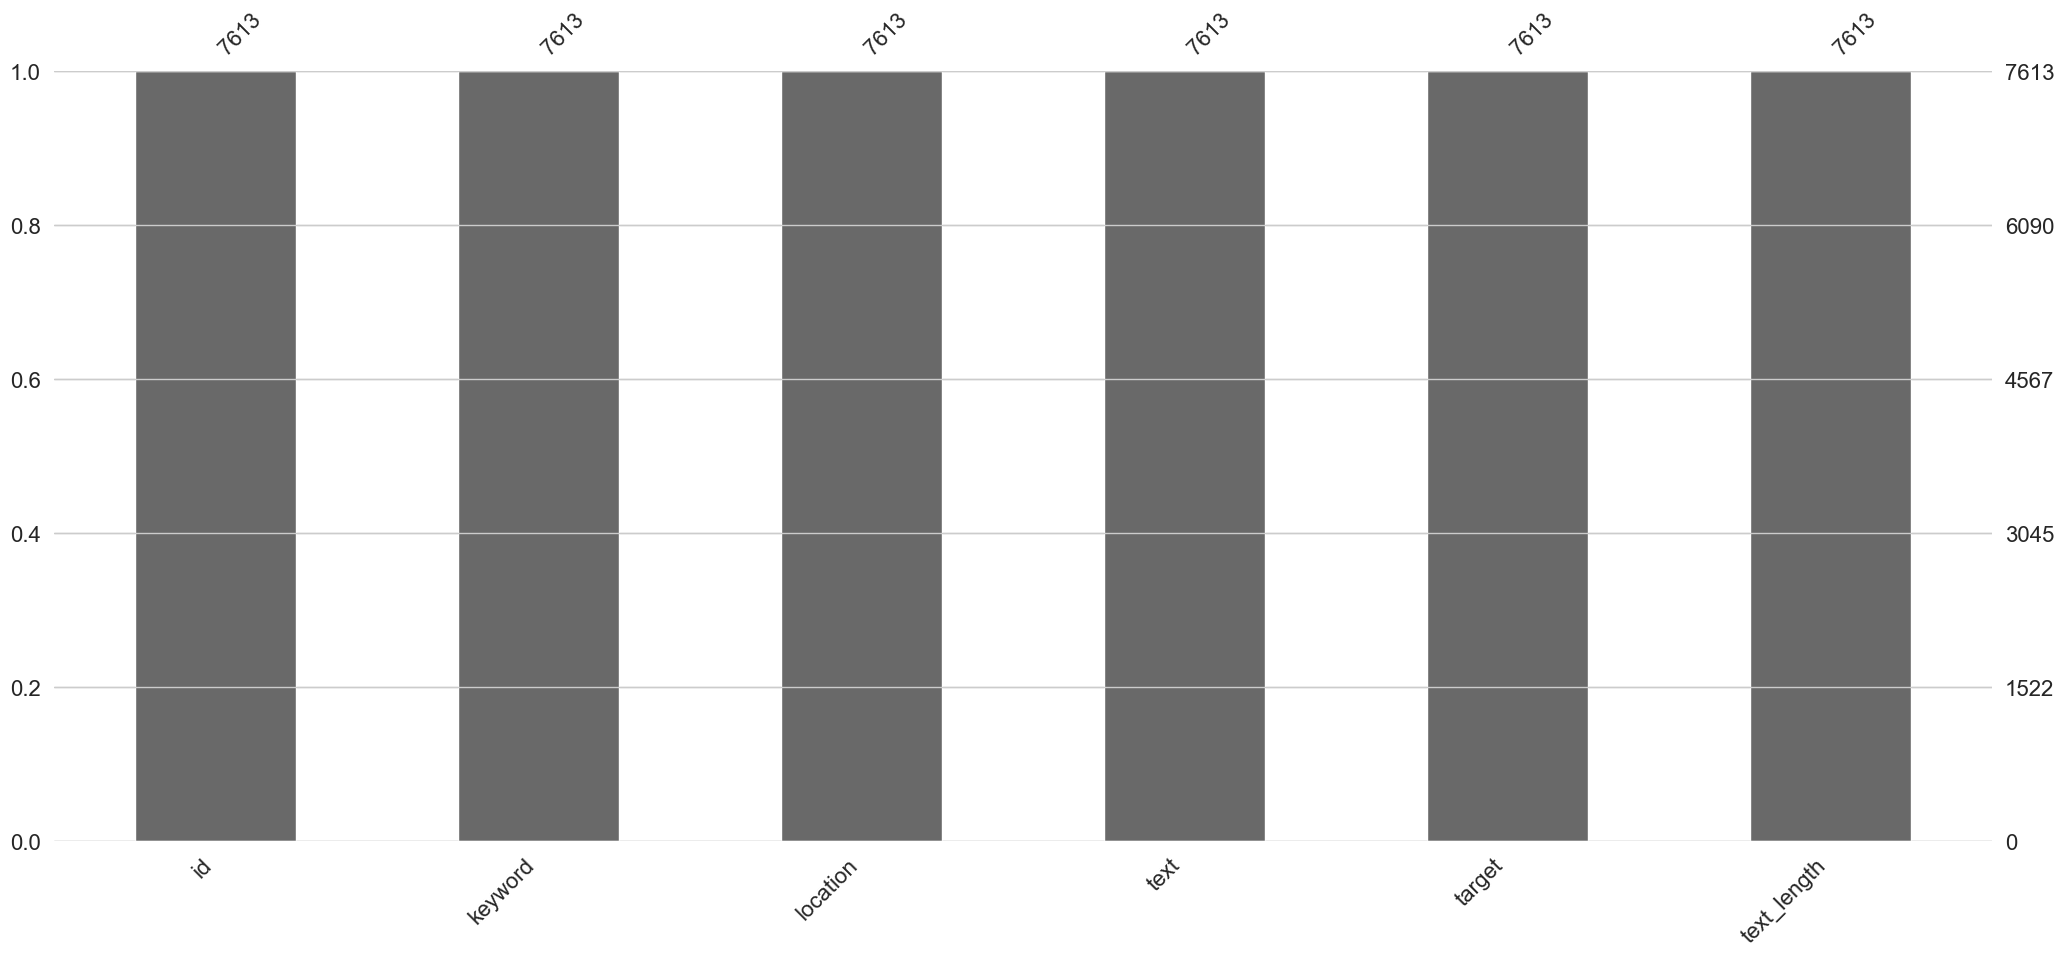

In [20]:
# Display without missing data
msno.bar(df)

#### Drop columns we don't need

In [21]:
df.drop(['id'], axis=1, inplace=True)

In [22]:
df.drop(['location'], axis=1, inplace=True)

In [23]:
df.head()

,keyword,text,target,text_length
0,Unknown,Our Deeds are the Reason of this #earthquake M...,1,69
1,Unknown,Forest fire near La Ronge Sask. Canada,1,38
2,Unknown,All residents asked to 'shelter in place' are ...,1,133
3,Unknown,"13,000 people receive #wildfires evacuation or...",1,65
4,Unknown,Just got sent this photo from Ruby #Alaska as ...,1,88


#### Text cleaning

In [24]:
# Aggiungi "http" e "https" alla lista di stop words
stop_words.update(['http', 'https'])

In [25]:
# Basic preprocessing function to clean the text data
def clean_text(text):
    # Convert text to lower case
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove user @ references and '#' from hashtags
    text = re.sub(r'\@\w+|\#|\$|\å|\û|\ï|\ª|\ê|\ç|\ìñ', ' ', text)
    # Remove punctuations
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove stop words
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

In [26]:
# Apply the clean_text function to both train and test datasets
df['clean_text'] = df['text'].apply(clean_text)

In [27]:
# Display the first few rows of the cleaned training dataset
print(df[['text', 'clean_text']].head())

                                                text   
0  Our Deeds are the Reason of this #earthquake M...  \
1             Forest fire near La Ronge Sask. Canada   
2  All residents asked to 'shelter in place' are ...   
3  13,000 people receive #wildfires evacuation or...   
4  Just got sent this photo from Ruby #Alaska as ...   

                                          clean_text  
0       deeds reason earthquake may allah forgive us  
1              forest fire near la ronge sask canada  
2  residents asked shelter place notified officer...  
3  people receive wildfires evacuation orders cal...  
4  got sent photo ruby alaska smoke wildfires pou...  


### 2.4 Train test split

In [28]:
df.head()

,keyword,text,target,text_length,clean_text
0,Unknown,Our Deeds are the Reason of this #earthquake M...,1,69,deeds reason earthquake may allah forgive us
1,Unknown,Forest fire near La Ronge Sask. Canada,1,38,forest fire near la ronge sask canada
2,Unknown,All residents asked to 'shelter in place' are ...,1,133,residents asked shelter place notified officer...
3,Unknown,"13,000 people receive #wildfires evacuation or...",1,65,people receive wildfires evacuation orders cal...
4,Unknown,Just got sent this photo from Ruby #Alaska as ...,1,88,got sent photo ruby alaska smoke wildfires pou...


In [29]:
# Train Test Split

X = df['clean_text']
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
# Crea DataFrame per set di addestramento e test
train_df = pd.DataFrame({'clean_text': X_train, 'target': y_train})
test_df = pd.DataFrame({'clean_text': X_test, 'target': y_test})

In [31]:
# Aggiungi una colonna per la lunghezza del testo
train_df['text_length'] = train_df['clean_text'].apply(len)
test_df['text_length'] = test_df['clean_text'].apply(len)

In [32]:
X_train.head()

4996    courageous honest analysis need use atomic bom...
3263    wld b shame golf cart became engulfed flames b...
4907    tell rescind medals honor given us soldiers ma...
2855    worried ca drought might affect extreme weathe...
4716               lava blast amp power red pantherattack
Name: clean_text, dtype: object

In [33]:
y_train.head()

4996    1
3263    0
4907    1
2855    1
4716    0
Name: target, dtype: int64

In [34]:
X_test

2644            new weapon cause unimaginable destruction
2227    f amp things gishwhes got soaked deluge going ...
5448    dt rt  col police catch pickpocket liverpool ...
132     aftershock back school kick great want thank e...
6845    response trauma children addicts develop defen...
                              ...                        
1835                                 skype crashed u host
506     christian attacked muslims temple mount waving...
3592    man charged fatal crash near dubbo refused bai...
6740    usnwsgov severe weather statement issued augus...
1634    great british ltbgtbakeltbgt offs back dorrets...
Name: clean_text, Length: 1523, dtype: object

In [35]:
y_test

2644    1
2227    0
5448    1
132     0
6845    0
       ..
1835    0
506     1
3592    1
6740    1
1634    0
Name: target, Length: 1523, dtype: int64

In [36]:
train_df.head()

,clean_text,target,text_length
4996,courageous honest analysis need use atomic bom...,1,93
3263,wld b shame golf cart became engulfed flames b...,0,57
4907,tell rescind medals honor given us soldiers ma...,1,77
2855,worried ca drought might affect extreme weathe...,1,62
4716,lava blast amp power red pantherattack,0,38


In [37]:
test_df.head()

,clean_text,target,text_length
2644,new weapon cause unimaginable destruction,1,41
2227,f amp things gishwhes got soaked deluge going ...,0,62
5448,dt rt  col police catch pickpocket liverpool ...,1,51
132,aftershock back school kick great want thank e...,0,81
6845,response trauma children addicts develop defen...,0,83


### 2.5 TF-IDF Vectorization

In [38]:
# Convert text data to feature vectors using TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


### 2.6 Class Balancing

In [39]:
# Check class distribution before balancing
print("Class distribution before balancing:")
print(y_train.value_counts(normalize=True))

Class distribution before balancing:
target
0    0.569458
1    0.430542
Name: proportion, dtype: float64


In [40]:
# Applica SMOTE per bilanciare le classi
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_tfidf, y_train)

In [41]:
# Check class distribution after balancing
print("Class distribution after balancing:")
print(pd.Series(y_train_balanced).value_counts(normalize=True))

Class distribution after balancing:
target
1    0.5
0    0.5
Name: proportion, dtype: float64


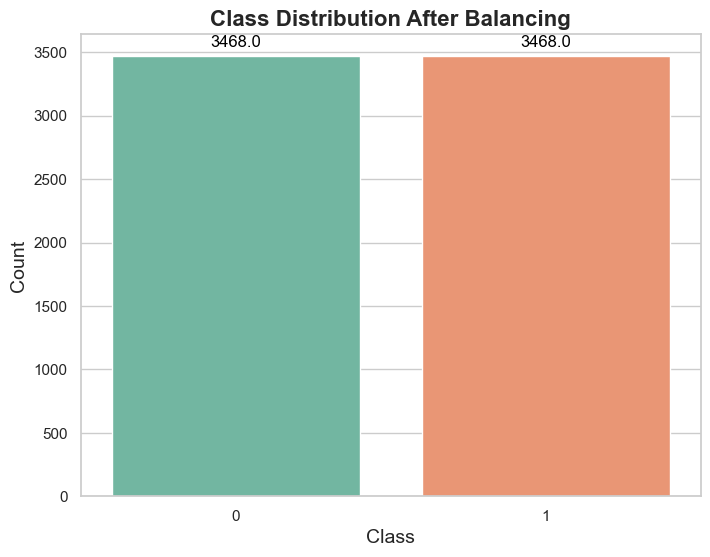

In [42]:
# Converti y_train_resampled in un DataFrame per l'uso con seaborn
y_train_resampled_df = pd.DataFrame(y_train_balanced, columns=['target'])

# Imposta lo stile e le dimensioni della figura
plt.figure(figsize=(8, 6))
sns.set(style="whitegrid")

# Crea il grafico a barre per visualizzare la distribuzione delle classi
sns.countplot(x='target', data=y_train_resampled_df, palette='Set2', hue='target', legend=False)

# Aggiungi le annotazioni per contare le occorrenze su ogni barra
for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height()}',
                       (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='center', xytext=(0, 10),
                       textcoords='offset points', fontsize=12, color='black')

# Aggiungi titolo e etichette con uno stile migliorato
plt.title('Class Distribution After Balancing', fontsize=16, fontweight='bold')
plt.xlabel('Class', fontsize=14)
plt.ylabel('Count', fontsize=14)

# Mostra il grafico
plt.show()

In [43]:
# Train a classifier (e.g., Naive Bayes) on the balanced dataset
classifier = MultinomialNB()
classifier.fit(X_train_balanced, y_train_balanced)

MultinomialNB()

In [44]:
# Valuta il classificatore sul set di test
y_pred = classifier.predict(X_test_tfidf)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.82      0.82       874
           1       0.75      0.74      0.75       649

    accuracy                           0.79      1523
   macro avg       0.78      0.78      0.78      1523
weighted avg       0.79      0.79      0.79      1523



#### Other methods for balancing classes and comparing them

##### B - Under-sampling the Majority Class

Random Under-Sampling reduces the number of examples in the majority class to match the minority class.

In [45]:
#rus.fit_resample(X_train, y_train):


# Initialize RandomUnderSampler
#rus = RandomUnderSampler(random_state=42)

# Resample the training set
#X_train_res, y_train_res = rus.fit_resample(X_train, y_train)

# Check the new class distribution
#print(pd.Series(y_train_res).value_counts())


##### C - Combining Over-sampling and Under-sampling

SMOTEENN combines SMOTE and the Edited Nearest Neighbors technique to balance and clean the dataset.

In [46]:
# Initialize SMOTEENN (SMOTE + Edited Nearest Neighbors)
#smote_enn = SMOTEENN(random_state=42)

# Resample the training set
#X_train_res, y_train_res = smote_enn.fit_resample(X_train, y_train)

# Check the new class distribution
#print(pd.Series(y_train_res).value_counts())


##### D - Using Class Weights

In [47]:
# Compute class weights
#class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
#class_weight_dict = dict(zip(np.unique(y_train), class_weights))

# Initialize the model with class weights
#model = LogisticRegression(class_weight=class_weight_dict, random_state=42)
#model.fit(X_train, y_train)

# Make predictions and evaluate
#y_pred = model.predict(X_test)
#print(classification_report(y_test, y_pred))


Precision for the minority class (e.g., class 1): Higher precision indicates fewer false positives.
Recall for the minority class (e.g., class 1): Higher recall indicates fewer false negatives.
F1-Score for the minority class (e.g., class 1): A balanced measure of precision and recall.

Evaluate Performance Before and After Using Class Weights

To confirm that using class weights has improved performance, compare the metrics from the classification report before and after applying class weights.

Before Applying Class Weights

Train a model without class weights and generate the classification report:

In [48]:
#model_no_weights = LogisticRegression(random_state=42)
#model_no_weights.fit(X_train, y_train)
#y_pred_no_weights = model_no_weights.predict(X_test)

#print("Classification Report without Class Weights:")
#print(classification_report(y_test, y_pred_no_weights))


In [49]:
#model_with_weights = LogisticRegression(class_weight=class_weight_dict, random_state=42)
#model_with_weights.fit(X_train, y_train)
#y_pred_with_weights = model_with_weights.predict(X_test)

#print("Classification Report with Class Weights:")
#print(classification_report(y_test, y_pred_with_weights))


In [50]:
# Plot class distribution in predictions
#plt.figure(figsize=(10, 6))
#sns.countplot(x=y_pred)
#plt.title('Distribution of Predicted Classes')
#plt.xlabel('Class')
#plt.ylabel('Count')
#plt.show()


In [51]:
# Perform cross-validation with class weights
#scores = cross_val_score(model_with_weights, X_train, y_train, cv=5, scoring='f1_weighted')
#print(f"Cross-Validation F1-Score: {scores.mean():.4f} ± {scores.std():.4f}")

##### Comparation of those 4 methods

In [52]:
# Example data creation (replace this with loading your dataset)
#X, y = make_classification(n_classes=2, class_sep=2, weights=[0.1, 0.9], n_informative=3, n_redundant=1, flip_y=0, n_features=20, n_clusters_per_class=1, n_samples=1000, random_state=42)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [53]:
#def train_and_evaluate(X_train, y_train, X_test, y_test, method_name):
#    model = LogisticRegression(random_state=42)
    
#    if method_name == 'Class Weights':
#        class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
#        class_weight_dict = dict(zip(np.unique(y_train), class_weights))
#        model = LogisticRegression(class_weight=class_weight_dict, random_state=42)
#    elif method_name == 'Over-sampling':
#        smote = SMOTE(random_state=42)
#        X_train, y_train = smote.fit_resample(X_train, y_train)
#    elif method_name == 'Under-sampling':
#        rus = RandomUnderSampler(random_state=42)
#        X_train, y_train = rus.fit_resample(X_train, y_train)
#    elif method_name == 'SMOTEENN':
#        smote_enn = SMOTEENN(random_state=42)
#        X_train, y_train = smote_enn.fit_resample(X_train, y_train)
    
#    model.fit(X_train, y_train)
#    y_pred = model.predict(X_test)
    
#    report = classification_report(y_test, y_pred, output_dict=True)
#    return report

#def collect_results(methods, X_train, y_train, X_test, y_test):
#    results = {}
#    for method in methods:
#        print(f"Evaluating method: {method}")
#        report = train_and_evaluate(X_train, y_train, X_test, y_test, method)
#        results[method] = report['1']  # '1' is the label for the positive class
#    return results

In [54]:
#methods = ['Class Weights', 'Over-sampling', 'Under-sampling', 'SMOTEENN']
#results = collect_results(methods, X_train, y_train, X_test, y_test)


In [55]:
# Convert results to DataFrame for easier visualization
#results_df = pd.DataFrame(results).T
#results_df = results_df[['precision', 'recall', 'f1-score', 'support']]

# Plotting
#plt.figure(figsize=(12, 8))
#results_df.plot(kind='bar', figsize=(12, 8))
#plt.title('Comparison of Class Imbalance Handling Methods')
#plt.xlabel('Method')
#plt.ylabel('Score')
#plt.legend(title='Metric')
#plt.grid(True)
#plt.xticks(rotation=45)
#plt.tight_layout()
#plt.show()


#### Finding the best "Max_features"

In [56]:
vectorizer = TfidfVectorizer(max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

num_unique_words = len(vectorizer.get_feature_names_out())

In [57]:
def evaluate_model(max_features, X_train, y_train, X_test, y_test):
    vectorizer = TfidfVectorizer(max_features=max_features)
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec = vectorizer.transform(X_test)

    # Model training
    model = LogisticRegression(max_iter=200)  # Puoi scegliere un modello differente
    model.fit(X_train_vec, y_train)
    y_pred = model.predict(X_test_vec)

    # Prediction and evaluation
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    return accuracy, recall, f1

In [58]:
# List of max_features values ​​to test
max_features_list = [1000, 3000, 3400, 3500, 3600, 5000, 6000, 7000, 10000, 12713]  # 12713 è il numero totale di parole uniche

# List to store results
results = []

# Evaluate the model for each max_features value
for max_features in max_features_list:
    accuracy, recall, f1 = evaluate_model(max_features, X_train, y_train, X_test, y_test)
    results.append((max_features, accuracy, recall, f1))
    print(f"max_features: {max_features}, Accuracy: {accuracy:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")


max_features: 1000, Accuracy: 0.7879, Recall: 0.6857, F1-Score: 0.7337
max_features: 3000, Accuracy: 0.7971, Recall: 0.6810, F1-Score: 0.7410
max_features: 3400, Accuracy: 0.8030, Recall: 0.6857, F1-Score: 0.7479
max_features: 3500, Accuracy: 0.8024, Recall: 0.6872, F1-Score: 0.7477
max_features: 3600, Accuracy: 0.8011, Recall: 0.6872, F1-Score: 0.7464
max_features: 5000, Accuracy: 0.8011, Recall: 0.6857, F1-Score: 0.7460
max_features: 6000, Accuracy: 0.8017, Recall: 0.6841, F1-Score: 0.7462
max_features: 7000, Accuracy: 0.8011, Recall: 0.6841, F1-Score: 0.7456
max_features: 10000, Accuracy: 0.7984, Recall: 0.6780, F1-Score: 0.7414
max_features: 12713, Accuracy: 0.7978, Recall: 0.6795, F1-Score: 0.7412


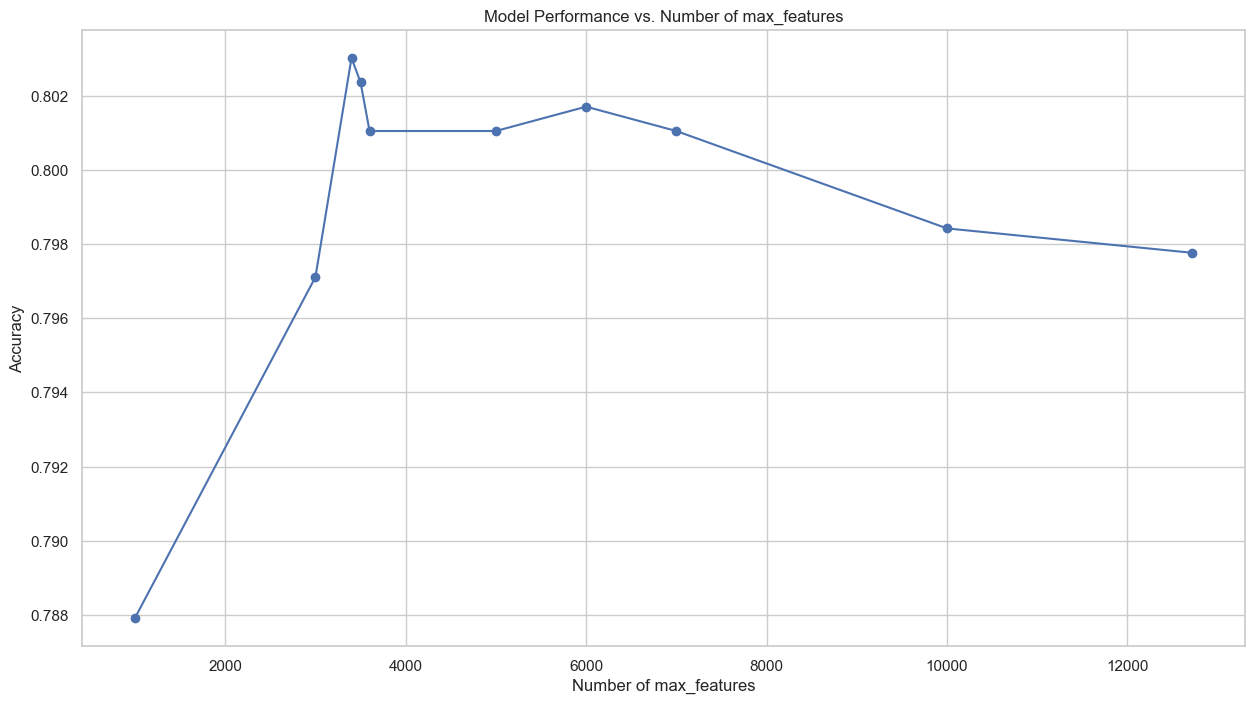

In [59]:
# Estrarre i valori di max_features e le rispettive accuratezze
max_features_values, accuracies, recalls, f1_scores = zip(*results)

plt.figure(figsize=(15, 8))

# Visualizzare le performance del modello per ciascun valore di max_features

plt.plot(max_features_values, accuracies, marker='o')
plt.title('Model Performance vs. Number of max_features')
plt.xlabel('Number of max_features')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

### 2.7 The length distribution of tweets

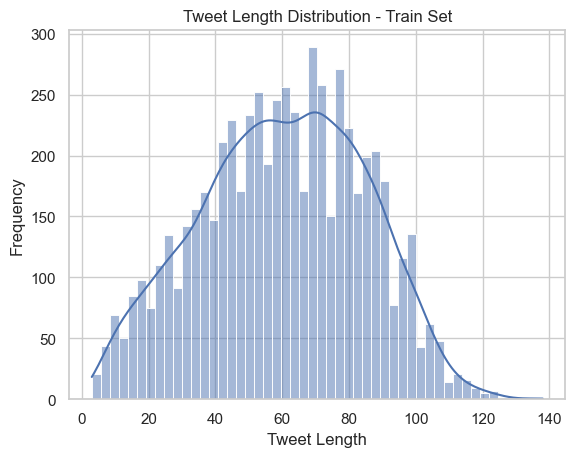

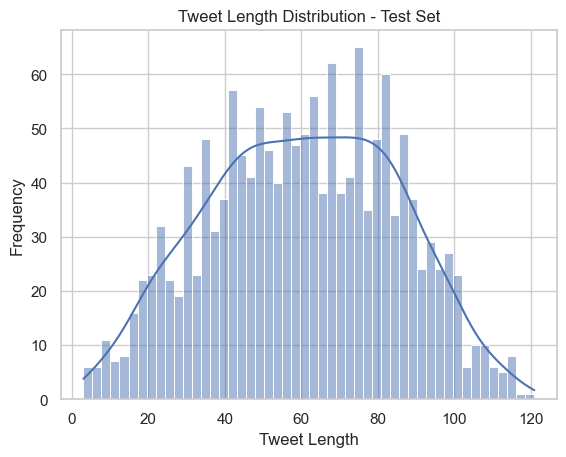

In [60]:
sns.histplot(train_df['text_length'], bins=50, kde=True)
plt.title('Tweet Length Distribution - Train Set')
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.show()

sns.histplot(test_df['text_length'], bins=50, kde=True)
plt.title('Tweet Length Distribution - Test Set')
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.show()

### 2.8 Analyze tweet lengths

In [61]:
# Get vocabulary
feature_names = vectorizer.get_feature_names_out()

# Display top 10 features
print("Top 10 features:", feature_names[:10])

# Display bottom 10 features
print("Bottom 10 features:", feature_names[-100:])

# Conta il numero totale di parole (feature)
total_words = len(feature_names)
print("Numero totale di parole nel vocabolario:", total_words)

Top 10 features: ['aa' 'aba' 'abandon' 'abandoned' 'abbott' 'abbswinston' 'abc' 'ability'
 'ablaze' 'able']
Bottom 10 features: ['witness' 'wmata' 'wmur' 'wmv' 'wnd' 'wo' 'wod' 'woke' 'wolf' 'wolves'
 'wom' 'woman' 'women' 'womens' 'wonder' 'wonderful' 'wondering' 'wont'
 'wood' 'word' 'words' 'work' 'worked' 'workers' 'working' 'works' 'world'
 'worldnews' 'worlds' 'worried' 'worry' 'worse' 'worst' 'worth' 'would'
 'wouldnt' 'wouldve' 'wound' 'wounded' 'wounds' 'wow' 'wrapup' 'wreck'
 'wreckage' 'wrecked' 'write' 'writer' 'writing' 'written' 'wrong'
 'wrought' 'wtf' 'wud' 'ww' 'wwii' 'wx' 'wy' 'xb' 'xbox' 'xd' 'xl' 'xoxo'
 'xp' 'xxx' 'ya' 'yahoo' 'yall' 'yay' 'yazidis' 'yea' 'yeah' 'year'
 'yearold' 'years' 'yes' 'yesterday' 'yet' 'yo' 'yobe' 'york' 'yorker'
 'you' 'youd' 'youll' 'young' 'youre' 'youth' 'youtube' 'youve' 'yr' 'yrs'
 'yugvani' 'yyc' 'yycstorm' 'zarry' 'zayn' 'zionist' 'zombie' 'zone'
 'zouma']
Numero totale di parole nel vocabolario: 5000


In [62]:
# Calculate the frequency of the top 10 words in the corpus
word_counts = X_train_vec.sum(axis=0).A1
sorted_word_counts = sorted(zip(word_counts, vectorizer.get_feature_names_out()), reverse=True)

# View top 10 words by frequency
top_n = 10
print(f"Top {top_n} words by frequency: {sorted_word_counts[:top_n]}")

Top 10 words by frequency: [(64.21276698395519, 'like'), (63.73771952724917, 'im'), (50.34419634626743, 'amp'), (48.350378197450496, 'fire'), (47.61724405515768, 'get'), (45.17702877873057, 'via'), (40.26140611359197, 'people'), (40.035144295798645, 'dont'), (39.548248311948804, 'one'), (39.270269921774876, 'new')]


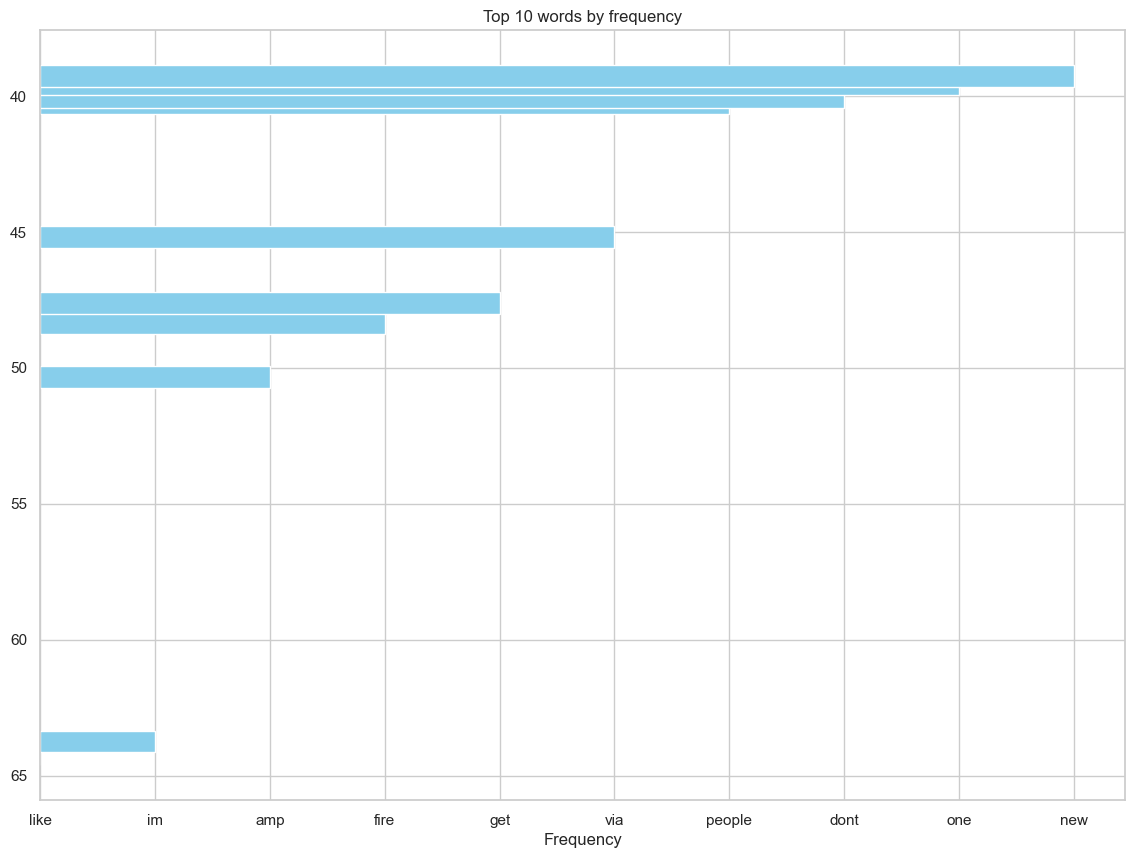

In [63]:
# View frequencies of the first 10 words
top_n = 10
top_words = sorted_word_counts[:top_n]

words, frequencies = zip(*top_words)
plt.figure(figsize=(14, 10))
plt.barh(words, frequencies, color='skyblue')
plt.gca().invert_yaxis()
plt.title(f"Top {top_n} words by frequency")
plt.xlabel("Frequency")
plt.show()

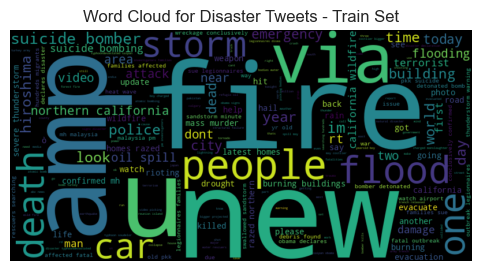

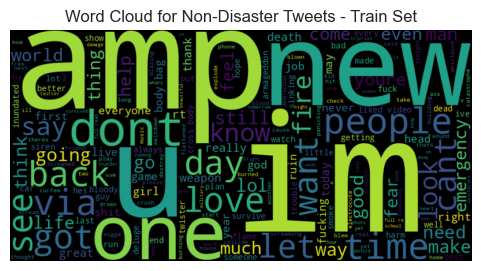

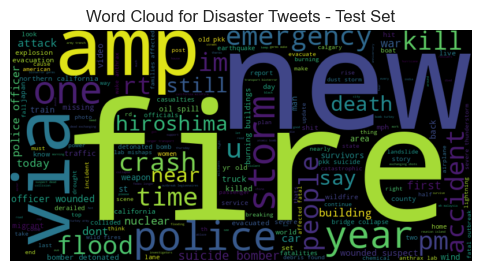

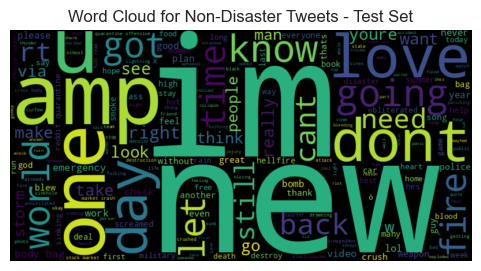

In [64]:
# Generate Word Cloud for Disaster Tweets in Training Set
train_df_disaster_tweets = train_df[train_df['target'] == 1]['clean_text'] 
wordcloud = WordCloud(width=800, height=400).generate(' '.join(train_df_disaster_tweets)) 
plt.figure(figsize=(7, 3)) 
plt.imshow(wordcloud, interpolation='bilinear') 
plt.axis('off') 
plt.title('Word Cloud for Disaster Tweets - Train Set') 
plt.show() 

# Generate Word Cloud for Non-Disaster Tweets in Training Set
non_disaster_tweets_train = train_df[train_df['target'] == 0]['clean_text'] 
wordcloud = WordCloud(width=800, height=400).generate(' '.join(non_disaster_tweets_train)) 
plt.figure(figsize=(7, 3)) 
plt.imshow(wordcloud, interpolation='bilinear') 
plt.axis('off') 
plt.title('Word Cloud for Non-Disaster Tweets - Train Set') 
plt.show()

# Generate Word Cloud for Disaster Tweets in Test Set
test_df_disaster_tweets = test_df[test_df['target'] == 1]['clean_text'] 
wordcloud = WordCloud(width=800, height=400).generate(' '.join(test_df_disaster_tweets)) 
plt.figure(figsize=(7, 3)) 
plt.imshow(wordcloud, interpolation='bilinear') 
plt.axis('off') 
plt.title('Word Cloud for Disaster Tweets - Test Set') 
plt.show() 

# Generate Word Cloud for Non-Disaster Tweets in Test Set
non_disaster_tweets_test = test_df[test_df['target'] == 0]['clean_text'] 
wordcloud = WordCloud(width=800, height=400).generate(' '.join(non_disaster_tweets_test)) 
plt.figure(figsize=(7, 3)) 
plt.imshow(wordcloud, interpolation='bilinear') 
plt.axis('off') 
plt.title('Word Cloud for Non-Disaster Tweets - Test Set') 
plt.show()

## Step 3: Feature Extraction

### 3.1 Dimensionality Reduction (Optional)

#### Cumulative Variance to decide the number of principal components

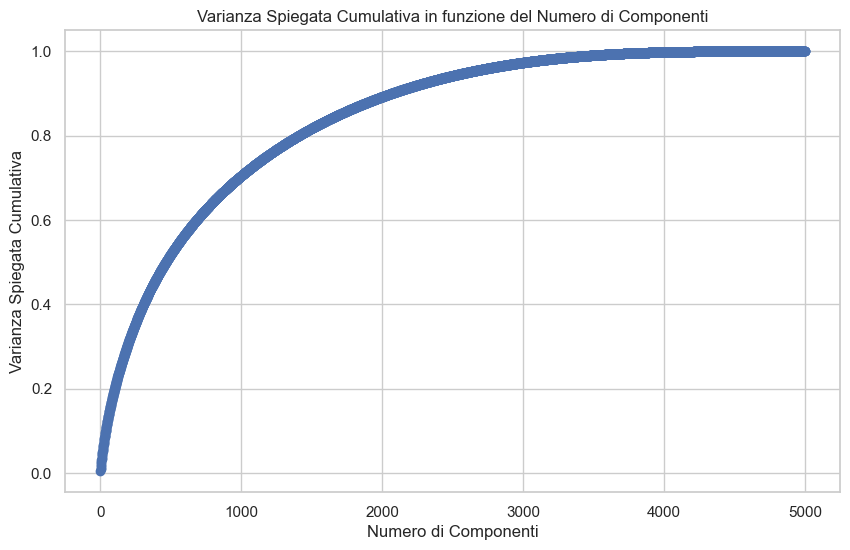

In [65]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X_train_tfidf.toarray())

# Cumulative Explained Variance
cum_var_exp = np.cumsum(pca.explained_variance_ratio_)

# Plot Cumulative Explained Variance
plt.figure(figsize=(10, 6))
plt.plot(cum_var_exp, marker='o', linestyle='--')
plt.xlabel('Numero di Componenti')
plt.ylabel('Varianza Spiegata Cumulativa')
plt.title('Varianza Spiegata Cumulativa in funzione del Numero di Componenti')
plt.grid(True)
plt.show()

In [66]:
# Choose the number of components corresponding to the point where the curve begins to stabilize and reaches the desired threshold of explained variance.

#### Dimensionality Reduction

In [67]:
pca = PCA(n_components=3500)
X_train_pca = pca.fit_transform(X_train_tfidf.toarray())
X_test_pca = pca.transform(X_test_tfidf.toarray())

## Step 4: Model Building

### 4.1 Logistic Regression

#### Without PCA

##### Logistic Regression without Hyperparameter

In [68]:
logreg = LogisticRegression()
logreg.fit(X_train_tfidf, y_train)
y_pred = logreg.predict(X_test_tfidf)
print(classification_report(y_test, y_pred, digits=4))
print('Recall:', recall_score(y_test, y_pred))

              precision    recall  f1-score   support

           0     0.7872    0.8844    0.8330       874
           1     0.8133    0.6780    0.7395       649

    accuracy                         0.7965      1523
   macro avg     0.8002    0.7812    0.7862      1523
weighted avg     0.7983    0.7965    0.7931      1523

Recall: 0.6779661016949152


##### Logistic Regression with Hyperparameter

In [69]:
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='recall')
grid_search.fit(X_train_tfidf, y_train)
print('Best parameters:', grid_search.best_params_)
best_logreg = grid_search.best_estimator_
y_pred = best_logreg.predict(X_test_tfidf)
print(classification_report(y_test, y_pred, digits=4))
print('Recall:', recall_score(y_test, y_pred))

/Users/cosimocarl/Desktop/Spiced/Agosto/CapstoneProject/Capstone-Project/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/cosimocarl/Desktop/Spiced/Agosto/CapstoneProject/Capstone-Project/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documen

Best parameters: {'C': 10}
              precision    recall  f1-score   support

           0     0.7991    0.8238    0.8113       874
           1     0.7524    0.7211    0.7364       649

    accuracy                         0.7800      1523
   macro avg     0.7758    0.7725    0.7738      1523
weighted avg     0.7792    0.7800    0.7794      1523

Recall: 0.7211093990755008


/Users/cosimocarl/Desktop/Spiced/Agosto/CapstoneProject/Capstone-Project/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/cosimocarl/Desktop/Spiced/Agosto/CapstoneProject/Capstone-Project/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documen

#### With PCA

##### LR Without Hyperparameter Tuning

In [70]:
# Logistic regression with data transformed by PCA
#logreg = LogisticRegression()
#logreg.fit(X_train_pca, y_train)
#y_pred = logreg.predict(X_test_pca)
#print(classification_report(y_test, y_pred, digits=4))
#print('Recall:', recall_score(y_test, y_pred))

##### LR With Hyperparameter Tuning

In [71]:
# Define grid parameters for logistic regression
#param_grid = {'C': [0.01, 0.1, 1, 10, 100]}

# Run GridSearchCV with the PCA-transformed data
#grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='recall')
#grid_search.fit(X_train_pca, y_train)

# Get the best model
#print('Best parameters:', grid_search.best_params_)
#best_logreg = grid_search.best_estimator_

# Make predictions with the best model on the transformed test data
#y_pred = best_logreg.predict(X_test_pca)

# Print the classification report and recall
#print(classification_report(y_test, y_pred, digits=4))
#print('Recall:', recall_score(y_test, y_pred))

### 4.2 Random Forest

#### Without PCA:

##### Without Hyperparameter Tuning

In [72]:
rf = RandomForestClassifier()
rf.fit(X_train_tfidf, y_train)
y_pred = rf.predict(X_test_tfidf)
print(classification_report(y_test, y_pred, digits=4))
print('Recall:', recall_score(y_test, y_pred))

              precision    recall  f1-score   support

           0     0.7856    0.8261    0.8054       874
           1     0.7483    0.6965    0.7215       649

    accuracy                         0.7708      1523
   macro avg     0.7670    0.7613    0.7634      1523
weighted avg     0.7697    0.7708    0.7696      1523

Recall: 0.6964560862865947


##### With Hyperparameter Tuning:

In [73]:
param_grid = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20, 30]}
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring='recall')
grid_search.fit(X_train_tfidf, y_train)
print('Best parameters:', grid_search.best_params_)
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test_tfidf)
print(classification_report(y_test, y_pred, digits=4))
print('Recall:', recall_score(y_test, y_pred))

Best parameters: {'max_depth': None, 'n_estimators': 50}
              precision    recall  f1-score   support

           0     0.7826    0.8238    0.8027       874
           1     0.7446    0.6918    0.7173       649

    accuracy                         0.7676      1523
   macro avg     0.7636    0.7578    0.7600      1523
weighted avg     0.7664    0.7676    0.7663      1523

Recall: 0.6918335901386748


#### With PCA:

##### RF without Hyperparameter Tuning:

In [74]:
# Train RandomForestClassifier model with PCA-transformed data
#rf = RandomForestClassifier()
#rf.fit(X_train_pca, y_train)

# Predictions on PCA-transformed test data
#y_pred = rf.predict(X_test_pca)

# Print classification report and recall
#print(classification_report(y_test, y_pred, digits=4))
#print('Recall:', recall_score(y_test, y_pred))

##### RF with Hyperparameter Tuning:

In [75]:
# Define grid parameters for the RandomForestClassifier model
#param_grid = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20, 30]}

# Run GridSearchCV on the PCA-transformed data
#grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring='recall')
#grid_search.fit(X_train_pca, y_train)

# Get the best model
#print('Best parameters:', grid_search.best_params_)
#best_rf = grid_search.best_estimator_

# Make predictions with the best model on the PCA-transformed test data
#y_pred = best_rf.predict(X_test_pca)

# Print the classification report and the recall
#print(classification_report(y_test, y_pred, digits=4))
#print('Recall:', recall_score(y_test, y_pred))

### 4.3 Support Vector Machine (SVM)

#### Without PCA

##### Without Hyperparameters:

In [76]:
svm = SVC()
svm.fit(X_train_tfidf, y_train)
y_pred = svm.predict(X_test_tfidf)
print(classification_report(y_test, y_pred, digits=4))
print('Recall:', recall_score(y_test, y_pred))

              precision    recall  f1-score   support

           0     0.7839    0.8924    0.8347       874
           1     0.8220    0.6687    0.7375       649

    accuracy                         0.7971      1523
   macro avg     0.8029    0.7806    0.7861      1523
weighted avg     0.8001    0.7971    0.7932      1523

Recall: 0.6687211093990755


##### With Hyperparameters:

In [77]:
param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='recall')
grid_search.fit(X_train_tfidf, y_train)
print('Best parameters:', grid_search.best_params_)
best_svm = grid_search.best_estimator_
y_pred = best_svm.predict(X_test_tfidf)
print(classification_report(y_test, y_pred, digits=4))
print('Recall:', recall_score(y_test, y_pred))

Best parameters: {'C': 10, 'kernel': 'linear'}
              precision    recall  f1-score   support

           0     0.7832    0.7689    0.7760       874
           1     0.6962    0.7134    0.7047       649

    accuracy                         0.7452      1523
   macro avg     0.7397    0.7411    0.7403      1523
weighted avg     0.7462    0.7452    0.7456      1523

Recall: 0.7134052388289677


#### With PCA

##### Without Hyperparameters:

In [78]:
# Train SVC model with PCA-transformed data
#svm = SVC()
#svm.fit(X_train_pca, y_train)

# Predictions on PCA-transformed test data
#y_pred = svm.predict(X_test_pca)

# Print classification report and recall
#print(classification_report(y_test, y_pred, digits=4))
#print('Recall:', recall_score(y_test, y_pred))

##### With Hyperparameters:

In [79]:
# Define grid parameters for the SVC model
#param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}

# Run GridSearchCV on the PCA-transformed data
#grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='recall')
#grid_search.fit(X_train_pca, y_train)

# Get the best model
#print('Best parameters:', grid_search.best_params_)
#best_svm = grid_search.best_estimator_

# Make predictions with the best model on the PCA-transformed test data
#y_pred = best_svm.predict(X_test_pca)

# Print the classification report and recall
#print(classification_report(y_test, y_pred, digits=4)) print('Recall:', recall_score(y_test, y_pred))

### 4.4 Gradient Boosting

#### Without PCA

##### Without Hyperparameters:

In [80]:
gb = GradientBoostingClassifier()
gb.fit(X_train_tfidf, y_train)
y_pred = gb.predict(X_test_tfidf)
print(classification_report(y_test, y_pred, digits=4))
print('Recall:', recall_score(y_test, y_pred))

              precision    recall  f1-score   support

           0     0.7015    0.9382    0.8027       874
           1     0.8475    0.4622    0.5982       649

    accuracy                         0.7354      1523
   macro avg     0.7745    0.7002    0.7005      1523
weighted avg     0.7637    0.7354    0.7156      1523

Recall: 0.4622496147919877


##### With Hyperparameters:

In [81]:
param_grid = {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 1]}
grid_search = GridSearchCV(GradientBoostingClassifier(), param_grid, cv=5, scoring='recall')
grid_search.fit(X_train_tfidf, y_train)
print('Best parameters:', grid_search.best_params_)
best_gb = grid_search.best_estimator_
y_pred = best_gb.predict(X_test_tfidf)
print(classification_report(y_test, y_pred, digits=4))
print('Recall:', recall_score(y_test, y_pred))

Best parameters: {'learning_rate': 1, 'n_estimators': 200}
              precision    recall  f1-score   support

           0     0.7484    0.7792    0.7635       874
           1     0.6852    0.6471    0.6656       649

    accuracy                         0.7229      1523
   macro avg     0.7168    0.7132    0.7145      1523
weighted avg     0.7214    0.7229    0.7218      1523

Recall: 0.6471494607087828


#### With PCA

##### Without Hyperparameters:

In [82]:
# Train the Gradient Boosting model with PCA-transformed data
#gb = GradientBoostingClassifier()
#gb.fit(X_train_pca, y_train)

# Make predictions on the PCA-transformed test data
#y_pred = gb.predict(X_test_pca)

# Print the classification report and recall score
#print(classification_report(y_test, y_pred, digits=4))
#print('Recall:', recall_score(y_test, y_pred))

##### With Hyperparameters:

In [83]:
# Define the parameter grid for the Gradient Boosting model
#param_grid = {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 1]}

# Perform GridSearchCV with PCA-transformed data
#grid_search = GridSearchCV(GradientBoostingClassifier(), param_grid, cv=5, scoring='recall')
#grid_search.fit(X_train_pca, y_train)

# Get the best model
#print('Best parameters:', grid_search.best_params_)
#best_gb = grid_search.best_estimator_

# Make predictions with the best model on the PCA-transformed test data
#y_pred = best_gb.predict(X_test_pca)

# Print the classification report and recall score
#print(classification_report(y_test, y_pred, digits=4))
#print('Recall:', recall_score(y_test, y_pred))

### 4.5 XGBoost

#### Without PCA

##### Without Hyperparameters:

In [84]:
xgb = XGBClassifier()
xgb.fit(X_train_tfidf, y_train)
y_pred = xgb.predict(X_test_tfidf)
print(classification_report(y_test, y_pred, digits=4))
print('Recall:', recall_score(y_test, y_pred))

              precision    recall  f1-score   support

           0     0.7450    0.8924    0.8121       874
           1     0.8025    0.5886    0.6791       649

    accuracy                         0.7630      1523
   macro avg     0.7738    0.7405    0.7456      1523
weighted avg     0.7695    0.7630    0.7554      1523

Recall: 0.588597842835131


##### With Hyperparameters:

In [85]:
param_grid = {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 1]}
grid_search = GridSearchCV(XGBClassifier(), param_grid, cv=5, scoring='recall')
grid_search.fit(X_train_tfidf, y_train)
print('Best parameters:', grid_search.best_params_)
best_xgb = grid_search.best_estimator_
y_pred = best_xgb.predict(X_test_tfidf)
print(classification_report(y_test, y_pred, digits=4))
print('Recall:', recall_score(y_test, y_pred))

Best parameters: {'learning_rate': 1, 'n_estimators': 200}
              precision    recall  f1-score   support

           0     0.7636    0.8021    0.7824       874
           1     0.7140    0.6656    0.6890       649

    accuracy                         0.7439      1523
   macro avg     0.7388    0.7338    0.7357      1523
weighted avg     0.7425    0.7439    0.7426      1523

Recall: 0.6656394453004623


#### With PCA

##### Without Hyperparameters:

In [86]:
# Train the XGBoost model with PCA-transformed data
#xgb = XGBClassifier()
#xgb.fit(X_train_pca, y_train)

# Make predictions on the PCA-transformed test data
#y_pred = xgb.predict(X_test_pca)

# Print the classification report and recall score
#print(classification_report(y_test, y_pred, digits=4))
#print('Recall:', recall_score(y_test, y_pred))

##### With Hyperparameters:

In [87]:
# Define the parameter grid for the XGBoost model
#param_grid = {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 1]}

# Perform GridSearchCV with PCA-transformed data
#grid_search = GridSearchCV(XGBClassifier(), param_grid, cv=5, scoring='recall')
#grid_search.fit(X_train_pca, y_train)

# Get the best model
#print('Best parameters:', grid_search.best_params_)
#best_xgb = grid_search.best_estimator_

# Make predictions with the best model on the PCA-transformed test data
#y_pred = best_xgb.predict(X_test_pca)

# Print the classification report and recall score
#print(classification_report(y_test, y_pred, digits=4))
#print('Recall:', recall_score(y_test, y_pred))

### 4.6 Neural Networks (Example with MLPClassifier)

#### Without PCA

##### Without Hyperparameters:

In [88]:
mlp = MLPClassifier()
mlp.fit(X_train_tfidf, y_train)
y_pred = mlp.predict(X_test_tfidf)
print(classification_report(y_test, y_pred, digits=4))
print('Recall:', recall_score(y_test, y_pred))

              precision    recall  f1-score   support

           0     0.7745    0.7426    0.7582       874
           1     0.6715    0.7088    0.6897       649

    accuracy                         0.7282      1523
   macro avg     0.7230    0.7257    0.7239      1523
weighted avg     0.7306    0.7282    0.7290      1523

Recall: 0.7087827426810478


##### With Hyperparameters:

In [89]:
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd']
}
grid_search = GridSearchCV(MLPClassifier(), param_grid, cv=5, scoring='recall')
grid_search.fit(X_train_tfidf, y_train)
print('Best parameters:', grid_search.best_params_)
best_mlp = grid_search.best_estimator_
y_pred = best_mlp.predict(X_test_tfidf)
print(classification_report(y_test, y_pred, digits=4))
print('Recall:', recall_score(y_test, y_pred))

/Users/cosimocarl/Desktop/Spiced/Agosto/CapstoneProject/Capstone-Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/cosimocarl/Desktop/Spiced/Agosto/CapstoneProject/Capstone-Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/cosimocarl/Desktop/Spiced/Agosto/CapstoneProject/Capstone-Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/cosimocarl/Desktop/Spiced/Agosto/CapstoneProject/Capstone-Project/.venv/lib/python3.11/site-packages/s

Best parameters: {'activation': 'relu', 'hidden_layer_sizes': (100,), 'solver': 'adam'}
              precision    recall  f1-score   support

           0     0.7677    0.7449    0.7561       874
           1     0.6696    0.6965    0.6828       649

    accuracy                         0.7242      1523
   macro avg     0.7187    0.7207    0.7194      1523
weighted avg     0.7259    0.7242    0.7249      1523

Recall: 0.6964560862865947


#### With PCA

##### Without Hyperparameters and with PCA

In [90]:
# Train the MLP model with PCA-transformed data
#mlp = MLPClassifier()
#mlp.fit(X_train_pca, y_train)

# Make predictions on the PCA-transformed test data
#y_pred = mlp.predict(X_test_pca)

# Print the classification report and recall score
#print(classification_report(y_test, y_pred, digits=4))
#print('Recall:', recall_score(y_test, y_pred))

##### With Hyperparameters and with PCA

In [91]:
# Define the parameter grid for the MLP model
#param_grid = {
#    'hidden_layer_sizes': [(50,), (100,), (50, 50)],
#    'activation': ['relu', 'tanh'],
#    'solver': ['adam', 'sgd']
#}

# Perform GridSearchCV with PCA-transformed data
#grid_search = GridSearchCV(MLPClassifier(), param_grid, cv=5, scoring='recall')
#grid_search.fit(X_train_pca, y_train)

# Get the best model
#print('Best parameters:', grid_search.best_params_)
#best_mlp = grid_search.best_estimator_

# Make predictions with the best model on the PCA-transformed test data
#y_pred = best_mlp.predict(X_test_pca)

# Print the classification report and recall score
#print(classification_report(y_test, y_pred, digits=4))
#print('Recall:', recall_score(y_test, y_pred))

## Step 5: Compare Models

### 5.1 Define all models for the baseline

In [92]:
# Define the models
models = {
    'Random Forest': RandomForestClassifier(),
    'Logistic Regression': LogisticRegression(),
    'SVM': SVC(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'XGBoost': XGBClassifier(),
    'LightGBM': LGBMClassifier(),
    'Neural Network': MLPClassifier()
}

In [93]:
# Define hyperparameter grids for models
param_grids = {
    'Random Forest': {'clf__n_estimators': [50, 100, 200], 'clf__max_depth': [10, 20, 30]},
    'Logistic Regression': {'clf__C': [0.01, 0.1, 1, 10, 100]},
    'SVM': {'clf__C': [0.1, 1, 10], 'clf__kernel': ['linear', 'rbf']},
    'Gradient Boosting': {'clf__n_estimators': [50, 100, 200], 'clf__learning_rate': [0.01, 0.1, 1]},
    'XGBoost': {'clf__n_estimators': [50, 100, 200], 'clf__learning_rate': [0.01, 0.1, 1]},
    'LightGBM': {'clf__n_estimators': [50, 100, 200], 'clf__learning_rate': [0.01, 0.1, 1]},
    'Neural Network': {'clf__hidden_layer_sizes': [(50,), (100,), (50, 50)], 'clf__activation': ['relu', 'tanh'], 'clf__solver': ['adam', 'sgd']}
}

In [94]:
# Define a function to create pipelines
def create_pipeline(model):
    return ImbPipeline([
        ('tfidf', TfidfVectorizer(stop_words='english', max_features=3500)),
        ('clf', model)
    ])

# Create pipelines for each model
pipelines = {name: create_pipeline(model) for name, model in models.items()}

# Dictionary to hold the results
results = {}

# Train and evaluate each model
for name, pipeline in pipelines.items():
    print(f"Training {name}...")
    pipeline.fit(X_train, y_train)
    
    # Make predictions
    y_pred = pipeline.predict(X_test)
    
    # Evaluate
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    classification_rep = classification_report(y_test, y_pred, digits=4)
    
    results[name] = {
        'Accuracy': accuracy,
        'Recall': recall,
        'F1 Score': f1,
        'Classification Report': classification_rep
    }
    
    print(f'{name} Accuracy: {accuracy}')
    print(f'{name} Recall: {recall}')
    print(f'{name} F1 Score: {f1}')
    print(f'{name} Classification Report:\n{classification_rep}')
    print("\n")


Training Random Forest...
Random Forest Accuracy: 0.768220617202889
Random Forest Recall: 0.6902927580893683
Random Forest F1 Score: 0.7173738991192955
Random Forest Classification Report:
              precision    recall  f1-score   support

           0     0.7822    0.8261    0.8036       874
           1     0.7467    0.6903    0.7174       649

    accuracy                         0.7682      1523
   macro avg     0.7644    0.7582    0.7605      1523
weighted avg     0.7671    0.7682    0.7668      1523



Training Logistic Regression...
Logistic Regression Accuracy: 0.799080761654629
Logistic Regression Recall: 0.6856702619414484
Logistic Regression F1 Score: 0.7441471571906354
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0     0.7910    0.8833    0.8346       874
           1     0.8135    0.6857    0.7441       649

    accuracy                         0.7991      1523
   macro avg     0.8023    0.7845    0.7894  

### 5.2 Create a Papeline Model

In [95]:
# Hyperparameter tuning for each model
for name, model in models.items():
    print(f"Grid Searching {name}...")
    
    pipeline = ImbPipeline([
        ('tfidf', TfidfVectorizer(stop_words='english', max_features=3500)),
        ('clf', model)
    ])
    
    grid_search = GridSearchCV(pipeline, param_grids[name], cv=5, scoring='recall', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    classification_rep = classification_report(y_test, y_pred, digits=4)
    
    results[name + ' (Tuned)'] = {
        'Best Parameters': grid_search.best_params_,
        'Accuracy': accuracy,
        'Recall': recall,
        'F1 Score': f1,
        'Classification Report': classification_rep
    }
    
    print(f"{name} (Tuned) Best Parameters: {grid_search.best_params_}")
    print(f"{name} (Tuned) Accuracy: {accuracy}")
    print(f"{name} (Tuned) Recall: {recall}")
    print(f"{name} (Tuned) F1 Score: {f1}")
    print(f"{name} (Tuned) Classification Report:\n{classification_rep}")
    print("\n")

Grid Searching Random Forest...
Random Forest (Tuned) Best Parameters: {'clf__max_depth': 30, 'clf__n_estimators': 50}
Random Forest (Tuned) Accuracy: 0.721602101116218
Random Forest (Tuned) Recall: 0.38212634822804314
Random Forest (Tuned) F1 Score: 0.5391304347826086
Random Forest (Tuned) Classification Report:
              precision    recall  f1-score   support

           0     0.6797    0.9737    0.8006       874
           1     0.9151    0.3821    0.5391       649

    accuracy                         0.7216      1523
   macro avg     0.7974    0.6779    0.6698      1523
weighted avg     0.7800    0.7216    0.6892      1523



Grid Searching Logistic Regression...


/Users/cosimocarl/Desktop/Spiced/Agosto/CapstoneProject/Capstone-Project/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/cosimocarl/Desktop/Spiced/Agosto/CapstoneProject/Capstone-Project/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documen

Logistic Regression (Tuned) Best Parameters: {'clf__C': 10}
Logistic Regression (Tuned) Accuracy: 0.778069599474721
Logistic Regression (Tuned) Recall: 0.7149460708782742
Logistic Regression (Tuned) F1 Score: 0.7330173775671405
Logistic Regression (Tuned) Classification Report:
              precision    recall  f1-score   support

           0     0.7958    0.8249    0.8101       874
           1     0.7520    0.7149    0.7330       649

    accuracy                         0.7781      1523
   macro avg     0.7739    0.7699    0.7716      1523
weighted avg     0.7771    0.7781    0.7773      1523



Grid Searching SVM...
SVM (Tuned) Best Parameters: {'clf__C': 10, 'clf__kernel': 'rbf'}
SVM (Tuned) Accuracy: 0.7760998030203545
SVM (Tuned) Recall: 0.6964560862865947
SVM (Tuned) F1 Score: 0.7261044176706827
SVM (Tuned) Classification Report:
              precision    recall  f1-score   support

           0     0.7875    0.8352    0.8107       874
           1     0.7584    0.6965    0.

/Users/cosimocarl/Desktop/Spiced/Agosto/CapstoneProject/Capstone-Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/cosimocarl/Desktop/Spiced/Agosto/CapstoneProject/Capstone-Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/cosimocarl/Desktop/Spiced/Agosto/CapstoneProject/Capstone-Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/cosimocarl/Desktop/Spiced/Agosto/CapstoneProject/Capstone-Project/.venv/lib/python3.11/site-packages/s

Neural Network (Tuned) Best Parameters: {'clf__activation': 'relu', 'clf__hidden_layer_sizes': (100,), 'clf__solver': 'adam'}
Neural Network (Tuned) Accuracy: 0.7242284963887065
Neural Network (Tuned) Recall: 0.7041602465331279
Neural Network (Tuned) F1 Score: 0.6851574212893553
Neural Network (Tuned) Classification Report:
              precision    recall  f1-score   support

           0     0.7709    0.7391    0.7547       874
           1     0.6672    0.7042    0.6852       649

    accuracy                         0.7242      1523
   macro avg     0.7190    0.7216    0.7199      1523
weighted avg     0.7267    0.7242    0.7251      1523





### 5.3 Determine the best model

In [96]:
# Determine the best model
best_model_name = max(results, key=lambda x: results[x].get('Recall', 0))
print(f"The best model based on Recall is: {best_model_name}")

The best model based on Recall is: Logistic Regression (Tuned)


In [97]:
# Save the best model
best_pipeline_second_test = pipelines[best_model_name.replace(' (Tuned)', '')]
joblib.dump(best_pipeline_second_test, 'Second_test_best_pipeline_changing_orders.pkl')

['Second_test_best_pipeline_changing_orders.pkl']

## 6 Play with the Final model

In [100]:
# Load the trained model (replace 'best_pipeline.pkl' with your actual model filename)
model = joblib.load('best_pipeline.pkl')

# Function to make predictions
def predict_disaster(text):
    prediction = model.predict([text])
    return "Disaster" if prediction[0] == 1 else "Not a Disaster"

# Main function to test the model
def main():
    print("Welcome to the Disaster Prediction Test!")
    print("Type a sentence and see if the model predicts it as a disaster or not.")
    
    # Input sentence to test
    user_input = input("Enter a sentence: ")

    # Predict and display the result
    result = predict_disaster(user_input)
    print(f"\nPrediction: {result}")

if __name__ == "__main__":
    main()

Welcome to the Disaster Prediction Test!
Type a sentence and see if the model predicts it as a disaster or not.

Prediction: Not a Disaster
